In [98]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import skimage.transform as tf
import scipy.signal as signal
import re
import sys
def atoi(text):
    return int(text) if text.isdigit() else text.lower()
    
def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [99]:
filelist = glob.glob('figs/A/*.tiff')
filelist.sort(key=natural_keys)
print(filelist)
A_array = np.array([np.array(cv2.imread(fname, 0)) for fname in filelist])

['figs/A/Dark_amp.tiff', 'figs/A/Illumination_amp.tiff', 'figs/A/ITOfloating_amp.tiff', 'figs/A/Mofloating_amp.tiff']


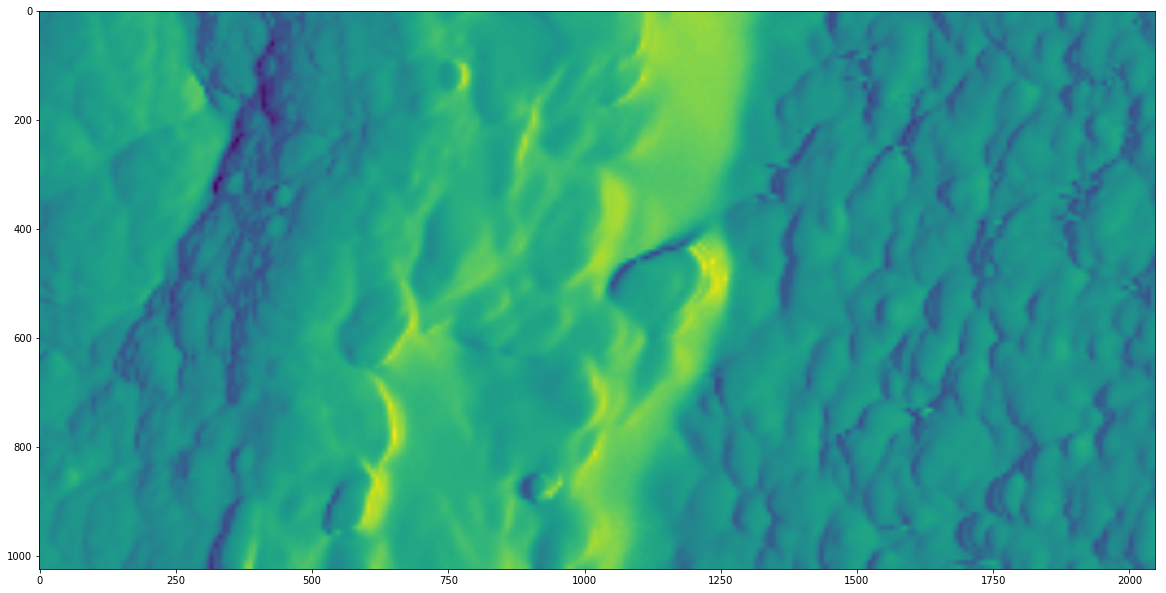

In [100]:
height, width = A_array[0].shape
dark_upsample = cv2.resize(A_array[0], (width*8, height*8), cv2.INTER_LANCZOS4)
plt.figure(figsize=(20,20))
plt.imshow(dark_upsample)
plt.show()

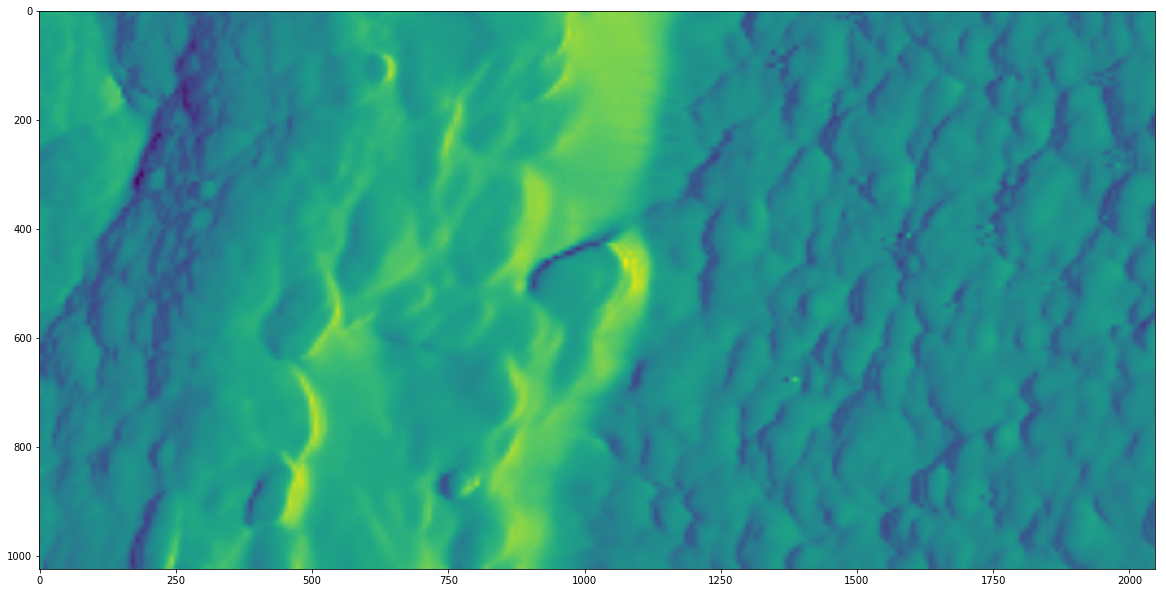

In [101]:
height, width = A_array[1].shape
illumination_upsample = cv2.resize(A_array[1], (width*8, height*8), cv2.INTER_LANCZOS4)
plt.figure(figsize=(20,20))
plt.imshow(illumination_upsample)
plt.show()

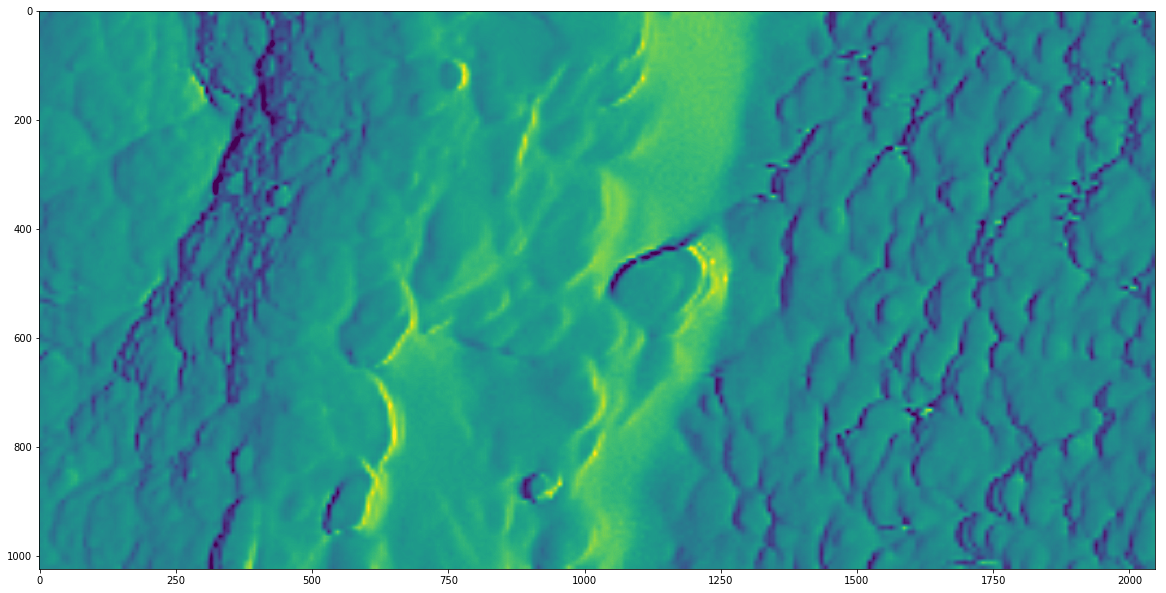

In [102]:
blur = cv2.GaussianBlur(dark_upsample, (25,25), 20)
dark_upsample_sharp = cv2.addWeighted(blur, -2, dark_upsample, 3,0)
plt.figure(figsize=(20,20))
plt.imshow(dark_upsample_sharp)
plt.show()

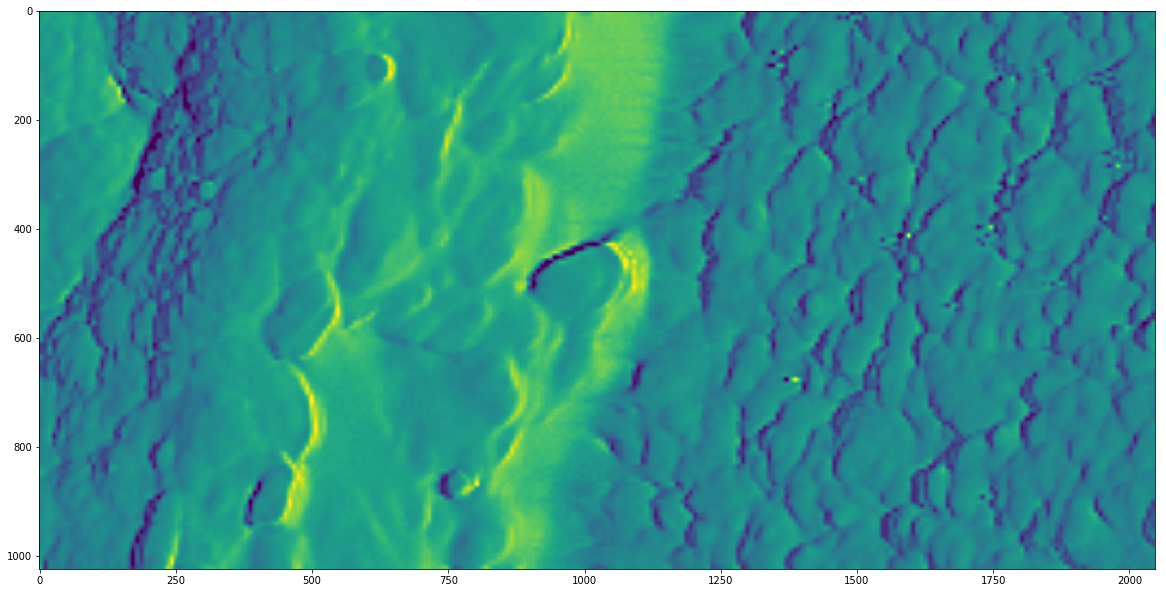

In [103]:
blur = cv2.GaussianBlur(illumination_upsample, (25,25), 20)
illumination_upsample_sharp = cv2.addWeighted(blur, -2, illumination_upsample, 3,0)
plt.figure(figsize=(20,20))
plt.imshow(illumination_upsample_sharp)
plt.show()

In [104]:
# import numpy as np
# from dipy.data import get_data
# from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
# from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
# import dipy.align.imwarp as imwarp
# from dipy.viz import regtools

In [105]:
# dim = dark_upsample.ndim
# metric = SSDMetric(dim)

# level_iters = [20, 20, 20]
# sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 100)

In [106]:
# warped = mapping.transform(dark_upsample_sharp)

In [107]:
# plt.figure(figsize=(20,20))
# plt.imshow(dark_upsample_sharp)
# plt.show()
# plt.figure(figsize=(20,20))
# plt.imshow(warped)
# plt.show()
# plt.figure(figsize=(20,20))
# plt.imshow(illumination_upsample_sharp)
# plt.show()


In [108]:
import SimpleITK as sitk
import sys
import os
import random

In [109]:
dark_proxy = sitk.GetImageFromArray(np.asarray(dark_upsample_sharp, dtype=np.float32))
illumination_proxy = sitk.GetImageFromArray(np.asarray(illumination_upsample_sharp, dtype=np.float32))

In [110]:
transformDomainMeshSize=[8]*dark_proxy.GetDimension()
tx = sitk.BSplineTransformInitializer(dark_proxy, transformDomainMeshSize )

In [111]:
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()

In [112]:
R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5,
                       numberOfIterations=20,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+7)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

In [113]:
counter = 0
def command_iteration(method) :
    global counter
    counter =+ 1
    if counter % 10 == 0:
        print("{0:3} = {1:10.5f}".format(method.GetOptimizerIteration(),
                                         method.GetMetricValue()))
R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )

0

In [114]:
outTx = R.Execute(dark_proxy, illumination_proxy)

In [115]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(dark_proxy);
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)

out = resampler.Execute(illumination_proxy)
simg1 = sitk.Cast(sitk.RescaleIntensity(dark_proxy), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)
#sitk.Show( cimg, "ImageRegistration1 Composition" )

In [116]:
nda = sitk.GetArrayFromImage(out)


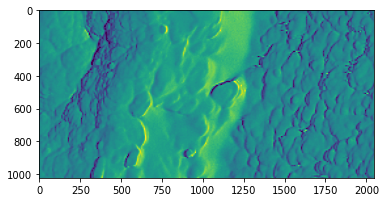

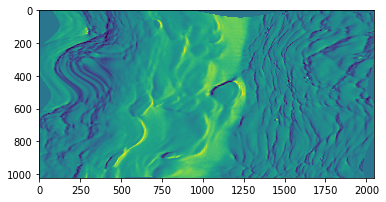

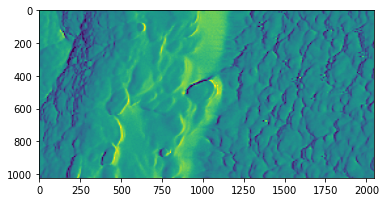

In [117]:
plt.imshow(dark_upsample_sharp)
plt.show()
plt.imshow(nda)
plt.show()
plt.imshow(illumination_upsample_sharp)